In [443]:
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Embedding, TimeDistributed, InputLayer
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [444]:
def replace_with_entity(re_group):
    # replace every ENAMEX tag in sentence with the entity itself
    entity = re.findall(r'<ENAMEX TYPE=.*?>(.*?)</ENAMEX>', re_group)
    return entity[0]


def find_index_in_sentence(patterns, sentence):
    # find index of start and end of occured entity in sentence
    index_in_sentence = []
    for pattern in patterns:
        # add regex special characters in pattern with backslash
        pattern = re.sub('\(', '\\(', pattern)
        pattern = re.sub('\)', '\\)', pattern)
        pattern = re.sub('\+', '\\+', pattern)
        pattern = re.sub('\$', '\\$', pattern)

        index_in_sentence.append([(index.start(0), index.end(0)) for index in re.finditer(pattern, sentence)][0])

    return index_in_sentence


def read_enamex_file(filename):
    # open file with enamex XML Entities
    # convert it to standard SpaCy training dataset for NER
    with open(filename, 'r') as f:
        content = f.read()

    # remove \t...\n from the content data
    content_removed_endline = re.sub('\t.*?\n', '', content)

    # split the content to list of sentences
    before_sentences = content_removed_endline.split(".")
    train_data = []

    # converted the splitted content to list of tuple
    # showing where the entity occur and what's the entity
    for each_sentence in before_sentences:
        if each_sentence == "":
            continue
        # find enamex for every sentence
        entities = re.findall(r'<ENAMEX TYPE=.*?>(.*?)</ENAMEX>', each_sentence)
        types = re.findall(r'<ENAMEX TYPE=\"(.*?)\">.*?</ENAMEX>', each_sentence)

        # replace XML ENAMEX with entity
        new_sentence = re.sub(r'<ENAMEX TYPE=.*?>.*?</ENAMEX>', lambda enamex: replace_with_entity(enamex.group()), each_sentence)

        index_in_sentence = find_index_in_sentence(entities, new_sentence)

        #append to train data with format = (new_sentence, {"entities": [(start, end, type)]})
        entity_dictionary = {
            "entities": []
        }

        for entity_type, entity_index in zip(types, index_in_sentence):
            # only append if entities don't overlap
            check_overlap = False
            for entity in entity_dictionary["entities"]:
                if ((entity_index[0] >= entity[0] and entity_index[0] <= entity[1]) or (entity_index[1] <= entity[1] and entity_index[1] >= entity[0])):
                    check_overlap = True

            if (not check_overlap and entity_type == 'DATETIME'):
                entity_dictionary["entities"].append((entity_index[0], entity_index[1], entity_type))
        train_data.append((new_sentence, entity_dictionary))

    return train_data

In [445]:
data_read = read_enamex_file('ner_data.txt')

In [446]:
def preprocessData(sentence):
  result = ' '.join(sentence.lower().split('-'))
  result = nltk.word_tokenize(result)
  return result

def changeDataFormat(data_read):
  x_data = []
  y_data = []
  # Label 0 = other, 1 = date
  for data in data_read:
    words = preprocessData(data[0])
    label = [0 for i in range(len(words))]
    for entities in data[1]['entities']:

      ner_words = data[0][entities[0]:entities[1]]
      ner_words = preprocessData(ner_words)

      ner_count = 0
      idx_word = 0
      while (ner_count < len(ner_words) and idx_word < len(words)):
        if words[idx_word] == ner_words[ner_count]:
          label[idx_word] = 1
          ner_count += 1
        idx_word += 1
    x_data.append(words)
    y_data.append(label)
  return x_data, y_data

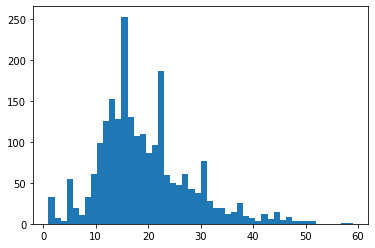

In [447]:
x, y = changeDataFormat(data_read)
x = np.array(x)
y = np.array(y)
plt.hist([len(s) for s in x], bins=50)
plt.show()

In [448]:
def encodeXData(x):
  new_x = []
  for sentence in x:
    new_seq = []
    for word in sentence:
      try:
        new_seq.append(word2index[word.lower()])
      except KeyError:
        new_seq.append(word2index['OOVword'])
    new_x.append(new_seq)
  return new_x


def dataToMaxLength(x, y, max_len):
  new_x = pad_sequences(maxlen=max_len, sequences=x, padding="post", value=0)
  new_y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)
  return np.array(new_x), np.array(new_y)

In [449]:
words = set([])
for sentence in x:
  for word in sentence:
    words.add(word.lower())
word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['PADword'] = 0
word2index['OOVword'] = 1
encoded_x = encodeXData(x)

In [450]:
MAX_LEN = 50
fixed_x = pad_sequences(maxlen=MAX_LEN, sequences=encoded_x, padding="post", value=0)
fixed_y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=0)
x_train = fixed_x
y_train = fixed_y
# x_train, x_test, y_train, y_test = train_test_split(fixed_x, fixed_y, test_size=0.1, random_state=13517054)

In [451]:
model = Sequential()
model.add(InputLayer(input_shape=(MAX_LEN, )))
model.add(Embedding(len(word2index), 64))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

In [452]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 50, 64)            482368    
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 50, 64)            24832     
_________________________________________________________________
time_distributed_22 (TimeDis (None, 50, 1)             65        
Total params: 507,265
Trainable params: 507,265
Non-trainable params: 0
_________________________________________________________________


In [453]:
history = model.fit(x_train, y_train, batch_size=32, validation_split=0.1, epochs=20)

Epoch 1/20
64/64 [==============================] - 2s 26ms/step - loss: 0.2010 - accuracy: 0.9783 - val_loss: 0.1061 - val_accuracy: 0.9777
Epoch 2/20
64/64 [==============================] - 1s 15ms/step - loss: 0.0326 - accuracy: 0.9945 - val_loss: 0.0918 - val_accuracy: 0.9777
Epoch 3/20
64/64 [==============================] - 1s 15ms/step - loss: 0.0238 - accuracy: 0.9945 - val_loss: 0.0802 - val_accuracy: 0.9777
Epoch 4/20
64/64 [==============================] - 1s 15ms/step - loss: 0.0174 - accuracy: 0.9945 - val_loss: 0.0694 - val_accuracy: 0.9777
Epoch 5/20
64/64 [==============================] - 1s 15ms/step - loss: 0.0114 - accuracy: 0.9951 - val_loss: 0.0578 - val_accuracy: 0.9786
Epoch 6/20
64/64 [==============================] - 1s 15ms/step - loss: 0.0070 - accuracy: 0.9973 - val_loss: 0.0497 - val_accuracy: 0.9810
Epoch 7/20
64/64 [==============================] - 1s 15ms/step - loss: 0.0046 - accuracy: 0.9984 - val_loss: 0.0429 - val_accuracy: 0.9831
Epoch 8/20
64

In [485]:
def getIndex(data):
  for key in word2index:
    if word2index[key] == data:
      return key

def predict(text):
  test_data = preprocessData(text)
  test_data = encodeXData([test_data])[0]
  pred = model.predict(test_data)
  normalized_pred = [1 if a > 0.5 else 0 for a in pred]
  labelled_token = []
  for i, label in enumerate(normalized_pred):
    if label == 1:
      labelled_token.append(getIndex(test_data[i]))
  return labelled_token

In [486]:
predict('mau cuti tanggal 11 20 januari hehe')

['11', '20', 'januari']